In [7]:
import os
os.chdir("/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic")

import numpy as np
from matplotlib import pyplot as plt
import h5py

from dynapseReservoir.networks.dynapseParameters import dynapseStructure
from dynapseReservoir.networks.reservoirsParameters import generalNetP, r64_1_1_P
from dynapseReservoir.networks.outputParameters import generalOutP
import DYNAPSETools.dynapseOutDecoder as DOD


plt.close("all")
%matplotlib tk


folderName = "/Users/liutianlin/Desktop/Academics/MINDS/neuromorphic/caer/myoutputs/thesis_output_aedat/"

 

Read all data

Extracted 1 experiments


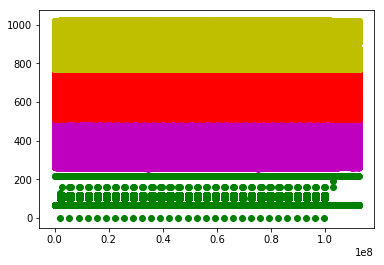

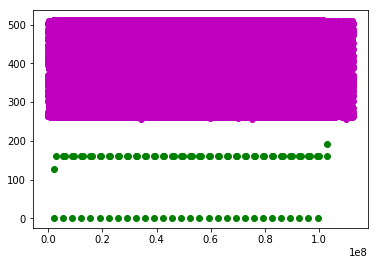

In [2]:

# experimentName = 'classificationBias_slowClassificationRes_seqPulse'

# experimentName = 'baselineBias_classificationRes_seqPulse'

experimentName = 'transferBias_transferRes3Cores_seqPulse'

inputRecording = experimentName + '.aedat'

outputDataset = experimentName + '.hdf5'

fileName =  os.path.join(folderName, inputRecording)


#for inputRecording, outputDataset in fileNames:
# ===============================================================================
# ===============================================================================
# ===============================================================================
# ====================== Import .AEDAT file
#fileName =  os.path.join(folderName, inputRecording)
decEvents = DOD.import_events(fileName)
decEvents = decEvents.normalize()
decEvents.plot_events()

# ====================== Define Filter events Core 0
filterCore0 = []
size = generalNetP["sizeTargetEncoding"] # WHAT IS sizeTargetEncoding??
U0, C0, N = generalNetP["targetEncodingPos"]
targetNeurons = [x for x in range(N, size + N)]
filterCore0 += targetNeurons

# Filter events taking only events that are important for elaboration
U0, C0, N1 = generalNetP["startTriggerPos"]
U0, C0, N2 = generalNetP["stopTriggerPos"]
U0, C0, N3 = generalNetP["endStimulusPos"]
filterCore0 += [N1, N2, N3]

# ====================== Define Filter events Core 1
#%%
size = r64_1_1_P["N_Res"]
U0, C1, N = generalNetP["reservoirStartPos"]
filterCore1 = [x for x in range(N, size + N)]
#%%

# ====================== Apply filter
neuron_id_filter = [filterCore0, filterCore1]
decFilteredEvents = decEvents.filter_events(chip_id = U0, core_id = [C0, C1], neuron_id = neuron_id_filter) # Take only events i need
decFilteredEvents.plot_events()

#%%
# ====================== Extract experiments
extractedEvents = decFilteredEvents.isolate_events_sets(startTriggerNeuron = generalNetP["startTriggerPos"],
                                                        stopTriggerNeuron = generalNetP["stopTriggerPos"],
                                                        maxNumber = None)
    
#%% Calculate the matrix of spike induced currents

totNeurons = dynapseStructure["nNeuronsPerChip"]
experiment = extractedEvents[0] # try a single experiment
#timeBin = generalOutP["timeBin"] # 0.1 second
alpha = 0.01


U, C, N = generalNetP["reservoirStartPos"]
startNeuronRes = dynapseStructure["nNeuronsPerCore"] * C + N
stopNeuronRes = startNeuronRes + r64_1_1_P["N_Res"]



sicMatrices = []

for experiment in extractedEvents:
    spikeInducedCurrent_allNeurons = experiment.calculate_sic_matrix(totNeurons, alpha, timeBin = generalOutP["timeBin"]*0.1)
    spikeInducedCurrentMat =  np.array(spikeInducedCurrent_allNeurons[startNeuronRes:stopNeuronRes])
    sicMatrices.append(spikeInducedCurrentMat[:,1:])

data = sicMatrices
    

# ====================== Create targets of dataset
outNotFiring = generalOutP["outNotFiring"]
# outFiring = generalOutP["outFiring"]
outFiring = 1

outNeurons = r64_1_1_P["N_out"]

# ====================== Create dataset
fileName = os.path.join(folderName, outputDataset)
h5f = h5py.File(fileName, "w")
dset = h5f.create_dataset("data", np.shape(data), dtype = "f")
dset[...] = data
# dset = h5f.create_dataset("target", np.shape(target), dtype = "f")
# dset[...] = target
h5f.close()
    
    
##


In [3]:
spikeTimeInSecond = experiment.ts[np.where(experiment.neuron_id == 160)[0]]/10**6
(spikeTimeInSecond[1:] - spikeTimeInSecond[:-1])[:2] # (the interval of between two pulses, the last time of a pulse).


array([2.852944, 0.502512])

256